# 1. Introdução

Este código tem como objetivo fazer uma estimativa de vendas com base em dados de notas fiscais forncecidos de um restaurante.

Os dados estão no formato **json**, **contendo 7 objeto com outro objetos ou arrays de objetos** dentro, sua estrutura é a seguinte:



*   **complemento**: 
  *   **valorTotal**:  indicando o valor total deste item na nota

*   **dets**: 
  *   **nItem**:  identificador do item no array de itens
  *   **prod**:  
     *   **indTot**:  identificador do item no array de itens
     *   **qCom**:  quantidade comercial
     *   **uCom**:  unidade de medida do produto utilizada para a sua comercialização
     *   **vProd**: valor do produto
     *   **vUnCom**: valor unitário de comercialização
     *   **xProd**: nome do produto
     
*   **emit**:  
   *   **cnpj**:  cnpj da empresa onde os dados foram coletados
   *   **orderEmit**:  
     *   **fone**:  telefone da empresa
     *   **uf**: estado
     *   **xBairro**: bairro
     *   **xLgr**: logradouro
     *   **xMun**: município
     *   **xPais**: país
  *   **xFant**: empresa que fez a coleta
*   **ide**:
  *   **dhEmi**:
      *   **$date**: data da emissão
      
   *   **natOp**:
   
*   **infAdic**: informações adicionais
  *   **infCpl**:
  
*   **total**:
  *   **icmsTot**:
      *   **vDesc**: somatório do desconto de todos os produtos
      *   **vFrete**: somatório do frete de todos os produtos
      *   **vOutro**: somatório do valor de outras despesas de todos os produtos
      *   **vProd**: somatório do valor de todos os produtos
      *   **vSeg**: somatório do valor do seguro de todos os produtos
      *   **vTotTrib**: valor do tributo cobrado
      *   **vbc**: base de cálculo do ICMS na operação
      *   **vbcst**: valor da base de cálculo do ICMS na operação sujeita à substituição tributária
      *   **vconfins**: valor da Contribuição para o Financiamento da Seguridade Social
      *   **vicms**: imposto sobre operações relativas à circulação de mercadorias e serviços
      *   **vicmsDeson**:  valor do ICMS desonerado
      *   **vii**: somatório do valor do Imposto de Importação de todos os produtos
      *   **vipi**: somatório do valor do IPI de todos os produtos
      *   **vnf**: valor da nota fiscal
      *   **vpis**:  valor total devido na operação para o Programa de Integração Social, se aplicável
      *   **vst**: somatório do valor do ICMS com Substituição Tributária de todos os produtos
      
*   **versaoDocumento**: Versão do documento, que atualmente é 1.0
      


**Tempo gasto nessa atividade: 30m**

# 2. Preparação

Foi feito o upload no google drive do arquivo com os dados necessário, sendo assim, utilizamos a biblioteca **pydrive** para baixá-lo.

In [0]:
# Instala a biblioteca, caso necessário
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import json
import sys
import numpy as np
import pandas as pd

# Autentica e cria o cliente PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Pega o arquivo para ser utilizado
downloaded = drive.CreateFile({'id': "1IhL1RBOX4kDXCXEi_2MPo8fCb0l72uXK"})
downloaded.GetContentFile('restaurant.txt')

with open('restaurant.txt', encoding='utf-8') as file:
  data = json.load(file)


In [3]:
# Vamos dar uma olhada no primeiro objeto do arquivo
data[0]

{'complemento': {'valorTotal': 24.9},
 'dets': [{'nItem': '1',
   'prod': {'indTot': '1',
    'qCom': 1.0,
    'uCom': 'UN',
    'vProd': 3.5,
    'vUnCom': 3.5,
    'xProd': 'AGUA'}},
  {'nItem': '2',
   'prod': {'indTot': '1',
    'qCom': 0.312,
    'uCom': 'KG',
    'vProd': 21.4,
    'vUnCom': 68.6,
    'xProd': 'BUFFET'}}],
 'emit': {'cnpj': '01.234.567/0001-89',
  'enderEmit': {'fone': '1-650-933-4902',
   'uf': 'CA',
   'xBairro': '',
   'xLgr': '650 Castro St. unit 210',
   'xMun': 'Mountain View',
   'xPais': 'United States'},
  'xFant': 'Analytica'},
 'ide': {'dhEmi': {'$date': '2016-01-05T12:01:54.000Z'}, 'natOp': 'VENDA'},
 'infAdic': {'infCpl': 'Mesa 2'},
 'total': {'icmsTot': {'vDesc': 0.0,
   'vFrete': 0.0,
   'vOutro': 0.0,
   'vProd': 24.9,
   'vSeg': 0.0,
   'vTotTrib': 2.53,
   'vbc': 0.0,
   'vbcst': 0.0,
   'vcofins': 0.0,
   'vicms': 0.0,
   'vicmsDeson': 0.0,
   'vii': 0.0,
   'vipi': 0.0,
   'vnf': 24.9,
   'vpis': 0.0,
   'vst': 0.0}},
 'versaoDocumento': 1.0}

Para trabalhar com estes dados, precisamos fazer o parsing do **json** em **DataFrame**, formato usado na biblioteca **pandas**, para que o dataset possa ser manipulado.

In [0]:
#labels: vDesc, vFrete, vOutro, vProd, vSeg, vTotTrib, vbc, vbcst, vicms, vicmsDeson, vii, vipi, vnf, vpis, vst, valorTotal
newdata = np.empty(shape=[0, 17])

for obj in data:
  icms = obj['total']['icmsTot']
  line = np.array([icms['vDesc'], icms['vFrete'], icms['vOutro'], icms['vProd'], icms['vSeg'],
                          icms['vTotTrib'], icms['vbc'], icms['vbcst'], icms['vicms'], icms['vicmsDeson'],
                          icms['vii'], icms['vipi'], icms['vnf'], icms['vpis'], icms['vst'], len(obj['dets']), obj['ide']['dhEmi']['$date']])
  newdata = np.append(newdata, [line], axis = 0)
 

Agora transformamos este **array** em um **DataFrame**.

In [5]:
columns = ['vDesc', 'vFrete', 'vOutro', 'vProd', 'vSeg', 'vTotTrib', 'vbc', 'vbcst', 'vicms', 'vicmsDeson', 'vii', 'vipi', 'vnf', 'vpis', 'vst', 'nItens', 'date']
data = pd.DataFrame(newdata, columns = columns)
data['date'] = pd.to_datetime(data['date']) # Converte a string em formate de data suportado pela biblioteca pandas
data.set_index('date', inplace=True) # Fazendo com que a coluna 'date' seja o novo index
data = data.apply(pd.to_numeric)
data.head()

,vDesc,vFrete,vOutro,vProd,vSeg,vTotTrib,vbc,vbcst,vicms,vicmsDeson,vii,vipi,vnf,vpis,vst,nItens
date,,,,,,,,,,,,,,,,
2016-01-05 12:01:54,0.0,0.0,0.0,24.90,0.0,2.53,0.0,0.0,0.0,0.0,0.0,0.0,24.90,0.0,0.0,2
2016-01-05 12:03:52,0.0,0.0,0.0,92.55,0.0,7.71,0.0,0.0,0.0,0.0,0.0,0.0,92.55,0.0,0.0,2
2016-01-05 12:16:40,0.0,0.0,0.0,57.87,0.0,2.43,0.0,0.0,0.0,0.0,0.0,0.0,57.87,0.0,0.0,2
2016-01-05 12:17:50,0.0,0.0,0.0,34.98,0.0,1.47,0.0,0.0,0.0,0.0,0.0,0.0,34.98,0.0,0.0,1
2016-01-05 12:18:35,0.0,0.0,0.0,46.23,0.0,1.94,0.0,0.0,0.0,0.0,0.0,0.0,46.23,0.0,0.0,1


In [6]:
# Formato do dataframe criado
data.shape

(1635, 16)

As notas ficas estão distribuídas no decorrer dos dias, precisamos assim, agrupá-las. Como este dataset é de um restaurante, não faria sentido agrupar os dados por **hora**, pois o horário de funcionamento de um restaurante geralmente é no período de almoço e jantar, sendo assim, vamos **agrupar todas as notas fiscais por dia**, fazendo a soma de todos as linhas de cada nota fiscal.

In [7]:
# Agrupamos por dia fazendo a soma de todas as notas fiscais existentes naquele dia
data = data.groupby(pd.Grouper(freq = 'D')).sum()
data.head()

,vDesc,vFrete,vOutro,vProd,vSeg,vTotTrib,vbc,vbcst,vicms,vicmsDeson,vii,vipi,vnf,vpis,vst,nItens
date,,,,,,,,,,,,,,,,
2016-01-05,0.0,0.0,0.0,6822.04,0.0,587.64,0.0,0.0,0.0,0.0,0.0,0.0,6726.36,0.0,0.0,270
2016-01-06,0.0,0.0,0.0,7648.30,0.0,695.04,0.0,0.0,0.0,0.0,0.0,0.0,6561.78,0.0,0.0,273
2016-01-07,0.0,0.0,0.0,3226.13,0.0,250.62,0.0,0.0,0.0,0.0,0.0,0.0,3137.31,0.0,0.0,152
2016-01-08,0.0,0.0,0.0,3050.64,0.0,249.25,0.0,0.0,0.0,0.0,0.0,0.0,3004.59,0.0,0.0,146
2016-01-09,0.0,0.0,0.0,3273.79,0.0,230.35,0.0,0.0,0.0,0.0,0.0,0.0,3229.91,0.0,0.0,121


In [8]:
# Novo formatado dos dados
data.shape

(19, 16)

Logo após o agrupamento por dia, o dataset que antes havia mais de **1.600** linhas, foi reduzido para  **19**

**Tempo gasto nessa atividade: 1h**

# 3. Análise dos dados

**3.1 Valores nulos**

Contagem de valores nulos no dataset.

In [9]:
data.isnull().sum()

vDesc         0
vFrete        0
vOutro        0
vProd         0
vSeg          0
vTotTrib      0
vbc           0
vbcst         0
vicms         0
vicmsDeson    0
vii           0
vipi          0
vnf           0
vpis          0
vst           0
nItens        0
dtype: int64

Como mostra acima, nenhum valor nulo está presente nos dados, então não será necessário um tratamento a respeito disso.
Vamos seguir para alguns gráficos para entendermos melhor esse dataset.

**3.2. Variações de preço**

Vamos plotar a variação de preço com base na data, que agora se encontra agrupada em dias.

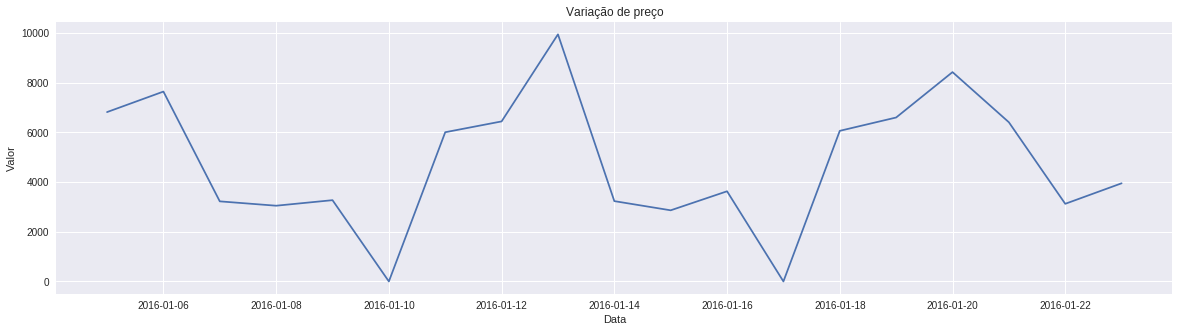

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

data = data.reset_index()

fig = plt.figure(figsize = (20, 5))
axl = fig.add_subplot(111)
axl.set_xlabel('Data')
axl.set_ylabel('Valor')
axl.set_title('Variação de preço')
axl.plot('date', 'vProd', data = data)


Por que os valores são zeros em **10/01** e **17/10**?
Bom, aparentemente o restaurante em questão não abre nos dias de **domingo**, já que as datas citadas acima são **domingo**. Vai usar essa informação na quando a previsão de vendas for criada.

Também podemos ver uma alta entre os dias **12/01** e **14/01**. O que poderia ser isso? Um evento?
Não é possível dizer com os dados que temos, como o dataset é pequeno isso provavelmente é um variação normal nos rendimentos do restaurante, se estivéssemos com mais dados talvez essa alta não seria notada.

In [11]:
data['vProd'].describe()

count      19.000000
mean     4776.844211
std      2672.798395
min         0.000000
25%      3176.540000
50%      3953.900000
75%      6525.045000
max      9952.930000
Name: vProd, dtype: float64

Agora podemos ver que o ganho médio deste restaurante, com base no dataset, é de pouco mais de **4.500 diários**.

**3.4 Relação dos atributos**

Vamos dar uma olhada na relação entre os atributos do dataset.

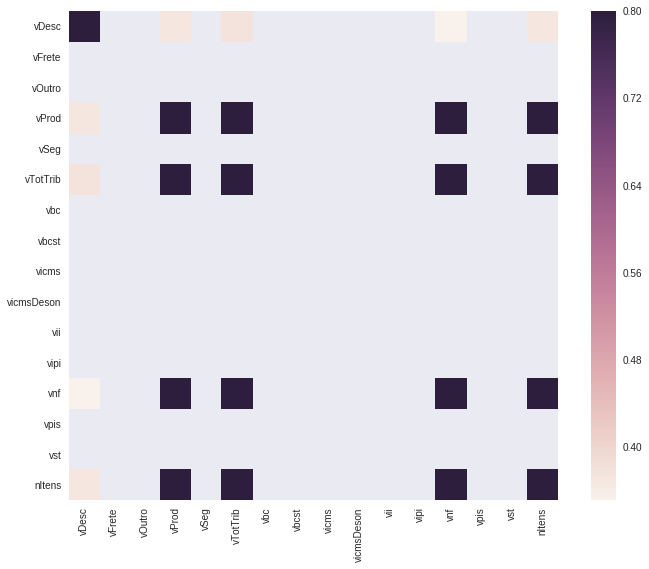

In [12]:
# Matriz de correlação, usada para observar a relação entre os atributos
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Como mostrado na matriz de correlação acima, os únicos atributos que se relação com o valor total da nota fiscal são: **vTotTrib, nItens, vnf, vDesc**, os demais atributos não possuem nenhuma relação com o atributo alvo da previsão (vProd), sendo assim, podemos descartá-los do dataset.

**3.5 Conclusão**

O dataset em questão é pequeno e simples no que diz respeito aos atributos, não possuindo muito o  que explorar para obtenção de novas informações, já que se trata de uma dataset de notas fiscais, 

**Tempo gasto nessa atividade: 1h30m**

# 4. Modelo

**4.1 Sobre o modelo**

Utilizaremos o **Prophet**, software open source criado pelo time de Data Science do **Facebook** com foco em **forecasting time series**. Essa biblioteca se baseia no **modelo aditivo**, onde tendências não lineares são analizadas por períodos anuais, mensais e diários. Como nosso dataset é pequeno, analizaremos com base em períodos mensais e semanais. Prophet é capaz de lidar com **valores inexistentes** e **outliers**.<br/>

Prophet está disponível para **Python** e **R**. Seguindo o modelo de API da blioteca **sklearn**, sua utilização é bem simples e intuitiva.


**4.2 Treinamento**

In [13]:
# Instalando o Prophet
!pip install -U -q fbprophet
from fbprophet import Prophet

  Failed building wheel for fbprophet


**Prophet** requer obrigatoriamente que o dataset contenha duas colunas, **ds** e **y**. A coluna **ds** é a data em timestamp e a coluna **y** é o valor que queremos prever.<br/>
Sendo assim, renomeamos as colunas do nosso dataset para o formatado aceitado pelo **Prophet**.


In [0]:
data = data[['date', 'vProd']].rename(columns = {'date': 'ds', 'vProd': 'y'})

Agora, para basta instanciar o **Prophet** e treiná-lo com o dataset que temos.

**4.3 Previsões**

Para efetuar as previsões de vendas, utilizamos o método **make_future_dataframe**, que simplesmente gera datas futuras para o período que passamos como argumento.

In [16]:
# Gera datas para 7 dias a partir de 23/01/2016
future_dates = model.make_future_dataframe(periods = 1*7)
# Realiza as previsões com as datas geradas
forecast = model.predict(future_dates)
# Escolhemos os atributos que mais interessam: 
# ds - datas
# ythat - previsões
# ythat_lower - faixa inferior confiança
# ythat_upper - faixa superior de confiança
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2016-01-05,6245.897012,5509.484119,7080.642986
1,2016-01-06,8307.197039,7541.714329,9079.380770
2,2016-01-07,3908.639802,3090.767071,4662.622295
3,2016-01-08,2629.104844,1924.115370,3444.215975
4,2016-01-09,3237.852980,2415.748853,4002.376772
5,2016-01-10,-146.974249,-896.406045,602.737560
6,2016-01-11,5821.516065,5101.111054,6618.587864
7,2016-01-12,6609.332138,5830.338835,7298.643106
8,2016-01-13,8670.632982,7903.579180,9444.268143
9,2016-01-14,4272.076562,3471.687041,4996.069399


Agora podemos plotar as **previsões** juntamente com os dados que tínhamos no dataset.

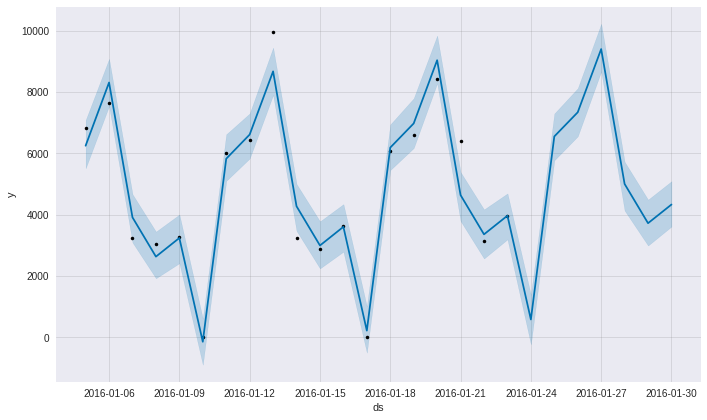

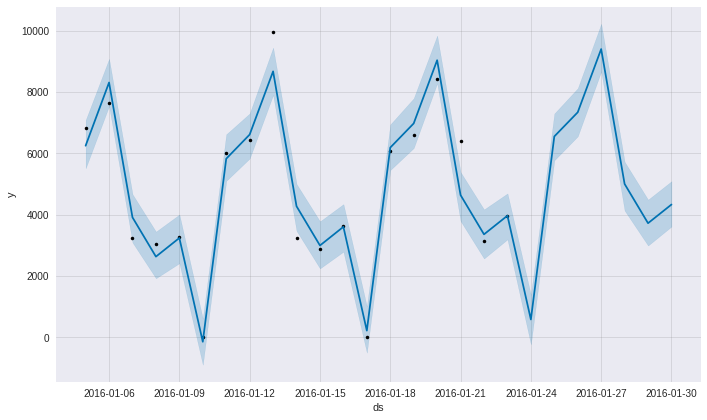

In [17]:
model.plot(forecast)

Podemos ver, as previsões, que seguem a partir do dia **24/01**, que as vendas tendem a seguir a tendência dos dias anteriores.<br/><br/>
Temos uma **sazonalidade semanal** no dataset. Os pontos pretos indicam os valores reais do dataset, a linha azul é a previsão e as faixas azul claras são o que o modelo chama de "**intervalos de confidência**", que são essencialmente margens de erro.<br/><br/>
Tendo em mente que o dia **24/01/2016** é um **domingo**, e como sabemos da análise do dataset, este restaurante não abre aos domingos, portanto, é fácil entender o motivo dos ganhos previstos para este dia sejam próximos a **zero**. 
É notada também uma semelhança muito grande entre a última parte do gráfico em preto (dataset) e a previsão em vermelho. Isso pode ter sido causado pela ausência de mais dados e atributos significativos, fazendo com que o modelo seja obrigado a replicar alguns valores já vistos no dataset.



**4.4 Análise dos resultados**

Agora vamos plotar os componentes que acompanham essa **time series**.

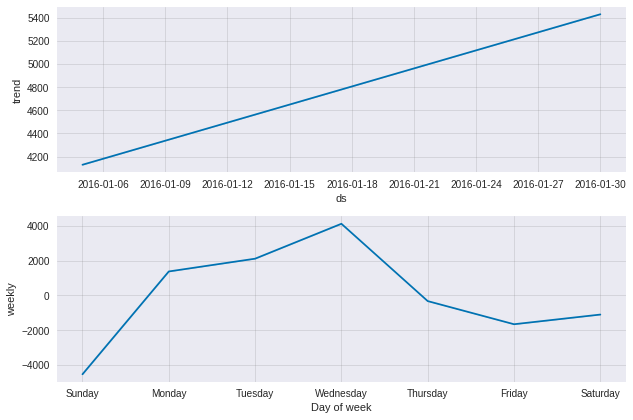

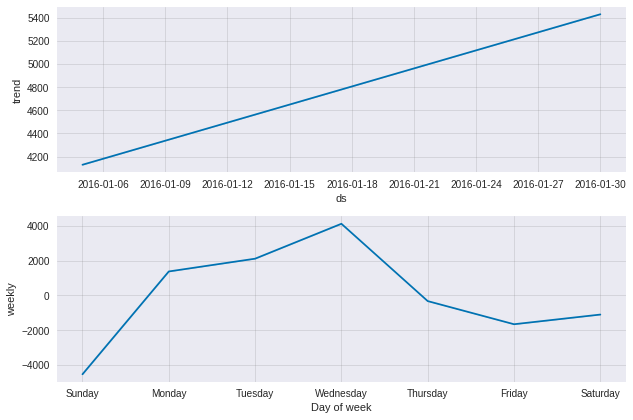

In [18]:
model.plot_components(forecast)

Temos então os gráficos de sazonalidade mensal e semanal.Já nos dois gráficos de tendências podemos ver que as **vendas do restaurante tendem a aumentar!**

**Tempo gasto nessa atividade: 2h**

# 5. Conclusão

Os modelo produzido mostrou que com base nos dados, podemos inferir que as vendas do restaurente em questão **tendem a aumentar significamente** nos dias posteriores aos do dataset. Claro que com mais dados e atributos, teríamos mais certeza sobre essa inferência. Contudo, com base na linha de tendência, é provável que as vendas aumentem.<br/><br/>
Terminamos aqui a preparação, análise e previsão das notas fiscais deste restaurante.

**Tempo total gasto: 5h**